<h1>laser_cutting_model<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-к-эксперименту" data-toc-modified-id="Подготовка-к-эксперименту-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка к эксперименту</a></span><ul class="toc-item"><li><span><a href="#Схемка-предобработки" data-toc-modified-id="Схемка-предобработки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Схемка предобработки</a></span></li><li><span><a href="#Эксперимент-1" data-toc-modified-id="Эксперимент-1-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Эксперимент 1</a></span></li><li><span><a href="#&quot;Pipeline&quot;" data-toc-modified-id="&quot;Pipeline&quot;-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>"Pipeline"</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Сравнение-моделей-на-графиках" data-toc-modified-id="Сравнение-моделей-на-графиках-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Сравнение моделей на графиках</a></span></li></ul></li></ul></div>

# Импорт библиотек

Импорты и функции вынесены в отдельный файл

In [43]:
from src.utils import *

# Подготовка к эксперименту 

Загрузим данные и сразу переименуем признаки

In [44]:
link = "../data/Лазерная резка.csv"
data = pd.read_csv(link, on_bad_lines="skip")
data.rename(columns={'Наименование': 'Part_name',
                        'Материал': 'Material',
                        'Время': 'Time',
                        'Ширина': 'Width',
                        'Длина': 'Length',
                        'Длина реза': 'Cut_length',
                        'Кол-во резов': 'Cut_quantity',
                        'Операция': 'Operation'}, inplace=True)

In [45]:
data.head()

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity
0,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
1,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
2,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
3,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1
4,Круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1


Удаляем дубли по hash

In [46]:
data.drop_duplicates(subset='hash', inplace=True)

Проведем несколько экспериментов, за baseline возьмем предсказание по формуле t = V*S,

Попробуем разную подготовку данных.

## Схемка предобработки

1. Столбец part_name:

    1.1 удалять\не удалять дубли
    
2. Столбец part_name - вытащить keywords
3. material:

    3.1 Сгруппировать материалы
    
    3.2 Вытащить из наименования материала марку и толщину (ошибки сразу удаляем, добавить фильтр по толщине 0<t<20)
    
    3.3 посчитать среднюю скорость резания, сгруперованную по материалу
    
4. Time преобразовать
5. W, L фильтр по размерам
6. заполнить пропуски
7. создать признаки
8. ввести фильтр на выбросы по cut_length + time
9. Преобразовать признаки
10. Поделить выборки

Разные подходы к обработке могут быть:

п.1 - удалять и нет

п.2 - разная логика формирования keywords

п.7 использовать разные признаки 

п.9 использовать разные кодировщики

## Эксперимент 1

## "Pipeline"

Скопируем данные для перевого эксперимента

In [47]:
exp1 = data.copy()

Для первого эксперимента не будем удалять дубли в наименовании изделия

Добавим признак keywords

In [48]:
exp1 = add_keywords(exp1, 'Part_name')
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count
0,круг 40,"Лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000
14,"след 1,3 ст3.л3,0","Лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000
17,100-15.214.03 перекладина низ,"Труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000


Добавим признак - тип материала

In [49]:
exp1['Material']=exp1['Material'].apply(lambda x: x.strip().lower())
exp1['Material_mark'] = exp1['Material'].apply(get_material_mark)
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000,Сталь
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000,Сталь
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь


Добавим толщину

In [50]:
exp1['Thickness'] = exp1['Material'].apply(extract_thickness)
exp1 = exp1[exp1['Thickness']!='Ошибка']
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,00:00:03.5,40.000,40.000,126,1,[круг],8.000,Сталь,3.000
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,00:00:07.5,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,00:00:46.7,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000


Преобразуем время

In [51]:
exp1['Time']=exp1['Time'].apply(convert_to_seconds)

Ошибка парсинга: time data '5мм\\Лист гк т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data 'т' does not match format '%H:%M:%S'
Ошибка парсинга: time data '260х60 (5,0)\\Лист гк т' does not match format '%H:%M:%S'


In [52]:
#Убираем время равное 0
exp1=exp1[exp1['Time']!=0]
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,4.000,40.000,40.000,126,1,[круг],8.000,Сталь,3.000
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,8.000,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,47.000,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000


Посчитаем среднегрупповую скорость резания

In [53]:
exp1['avg_group_speed'] = get_avg_group_speed(exp1)
exp1.head(3)

,Part_name,Material,Operation,hash,Time,Width,Length,Cut_length,Cut_quantity,keywords,keywords_count,Material_mark,Thickness,avg_group_speed
0,круг 40,"лист х/к т. 3,0 мм.",ЛР,42af1b9fc3,4.000,40.000,40.000,126,1,[круг],8.000,Сталь,3.000,38.510
14,"след 1,3 ст3.л3,0","лист х/к т. 3,0 мм.",ЛР,42d871d3ed,8.000,62.000,111.000,304,1,"[след, стл]",3.000,Сталь,3.000,38.510
17,100-15.214.03 перекладина низ,"труба проф. 40*40*2,0",ТР,1588a8230e,47.000,356.000,155.000,581,12,"[перекладина, низ]",93.000,Сталь,2.000,23.124


Фильтр по размерам листа

In [54]:
exp1 = sheet_size_filter(exp1)

Преобразуем материал

In [55]:
exp1 = add_one_hot(exp1, 'Material_mark')

Заолняем пропуски

In [56]:
columns=['Width', 'Length', 'Cut_length', 'Cut_quantity',
         'keywords_count', 'Thickness', 'Time',
         'avg_group_speed','Material_mark_09Г2С', 'Material_mark_60С2А', 'Material_mark_65Г',
         'Material_mark_CORTEN', 'Material_mark_Hardox', 'Material_mark_Алюминий', 
         'Material_mark_Латунь', 'Material_mark_Нержавейка', 'Material_mark_Оцинковка',
         'Material_mark_Сталь', 'Material_mark_Титан', 'Material_mark_бронза',
         'Material_mark_медь']  

In [57]:
fill_nan(exp1, columns, 'keywords_count')

Создаем признаки

In [58]:
features = ['Width', 'Length', 'Cut_length', 'Cut_quantity',
            'keywords_count', 'Material_mark', 'Thickness', 
            'avg_group_speed', 'density', 'L/W']

In [59]:
exp1['density'] = (
    (exp1['Cut_length'] * exp1['Cut_quantity']) /
    (exp1['Width'] * exp1['Length'])
)

In [60]:
exp1['L/W'] = exp1['Length'] / exp1['Width']

In [61]:
mapping = {'ЛР': 1,
          'ТР': 2}

exp1['operation_num'] = exp1['Operation'].replace(mapping)

/tmp/ipykernel_3443/3332241671.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exp1['operation_num'] = exp1['Operation'].replace(mapping)


Фильтр по времени и длине реза

In [62]:
exp1 = exp1[~(exp1["Cut_length"] > 15000) & (exp1['Time'] < 500)]

/home/mikhail/projects/laser_cutting/notebooks/src/utils.py:221: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=90)
/home/mikhail/projects/laser_cutting/notebooks/src/utils.py:222: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[row, col].set_xticklabels(ax[row, col].get_xticklabels(), rotation=90)


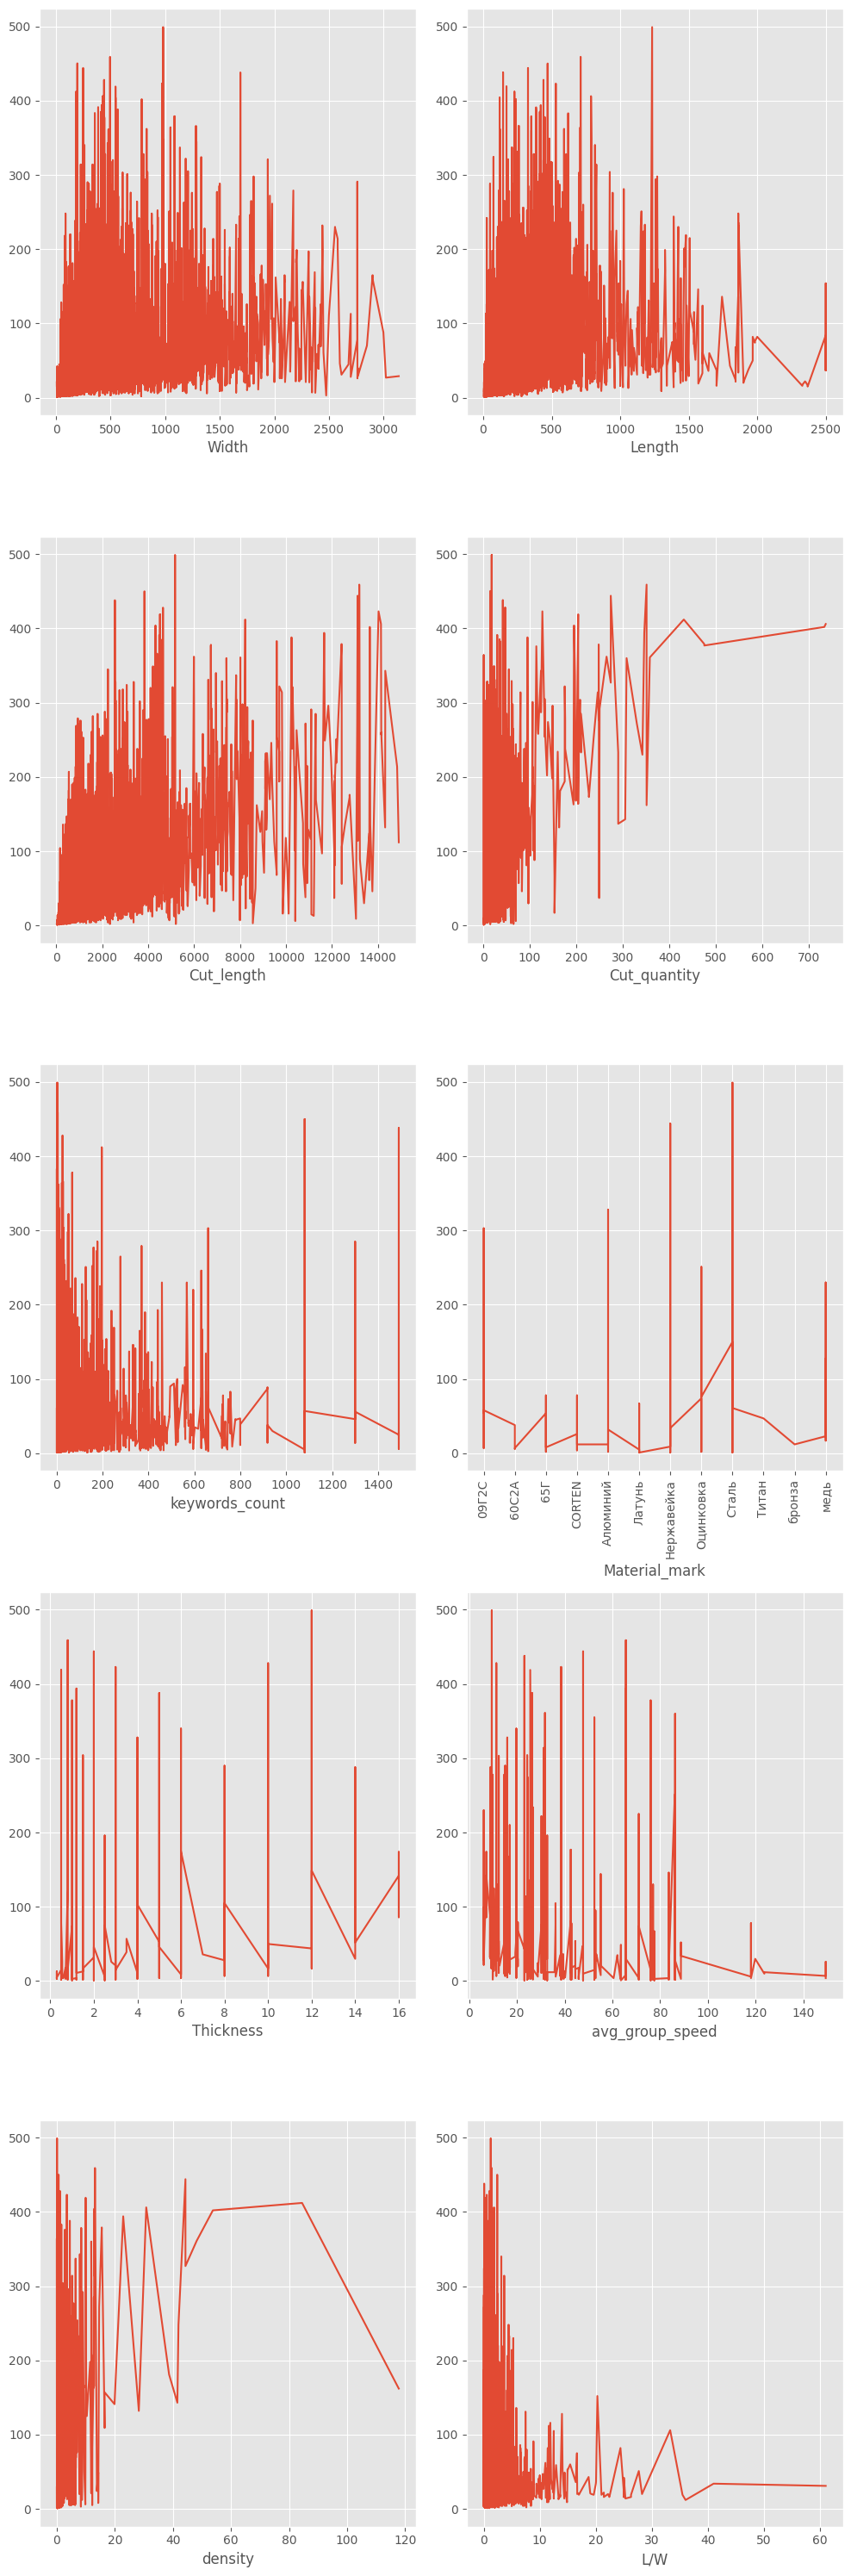

In [63]:
print_grafs(exp1, features, 2)

## Обучение моделей

Посмотрим на корреляционную матрицу, чтобы выбрать признаки для обучения

Сначала убираем нечисловые признаки

In [64]:
to_drop=['Part_name', 'Material', 'Operation', 'hash', 'keywords','Material_mark']
exp1.drop(to_drop, inplace=True, axis=1)

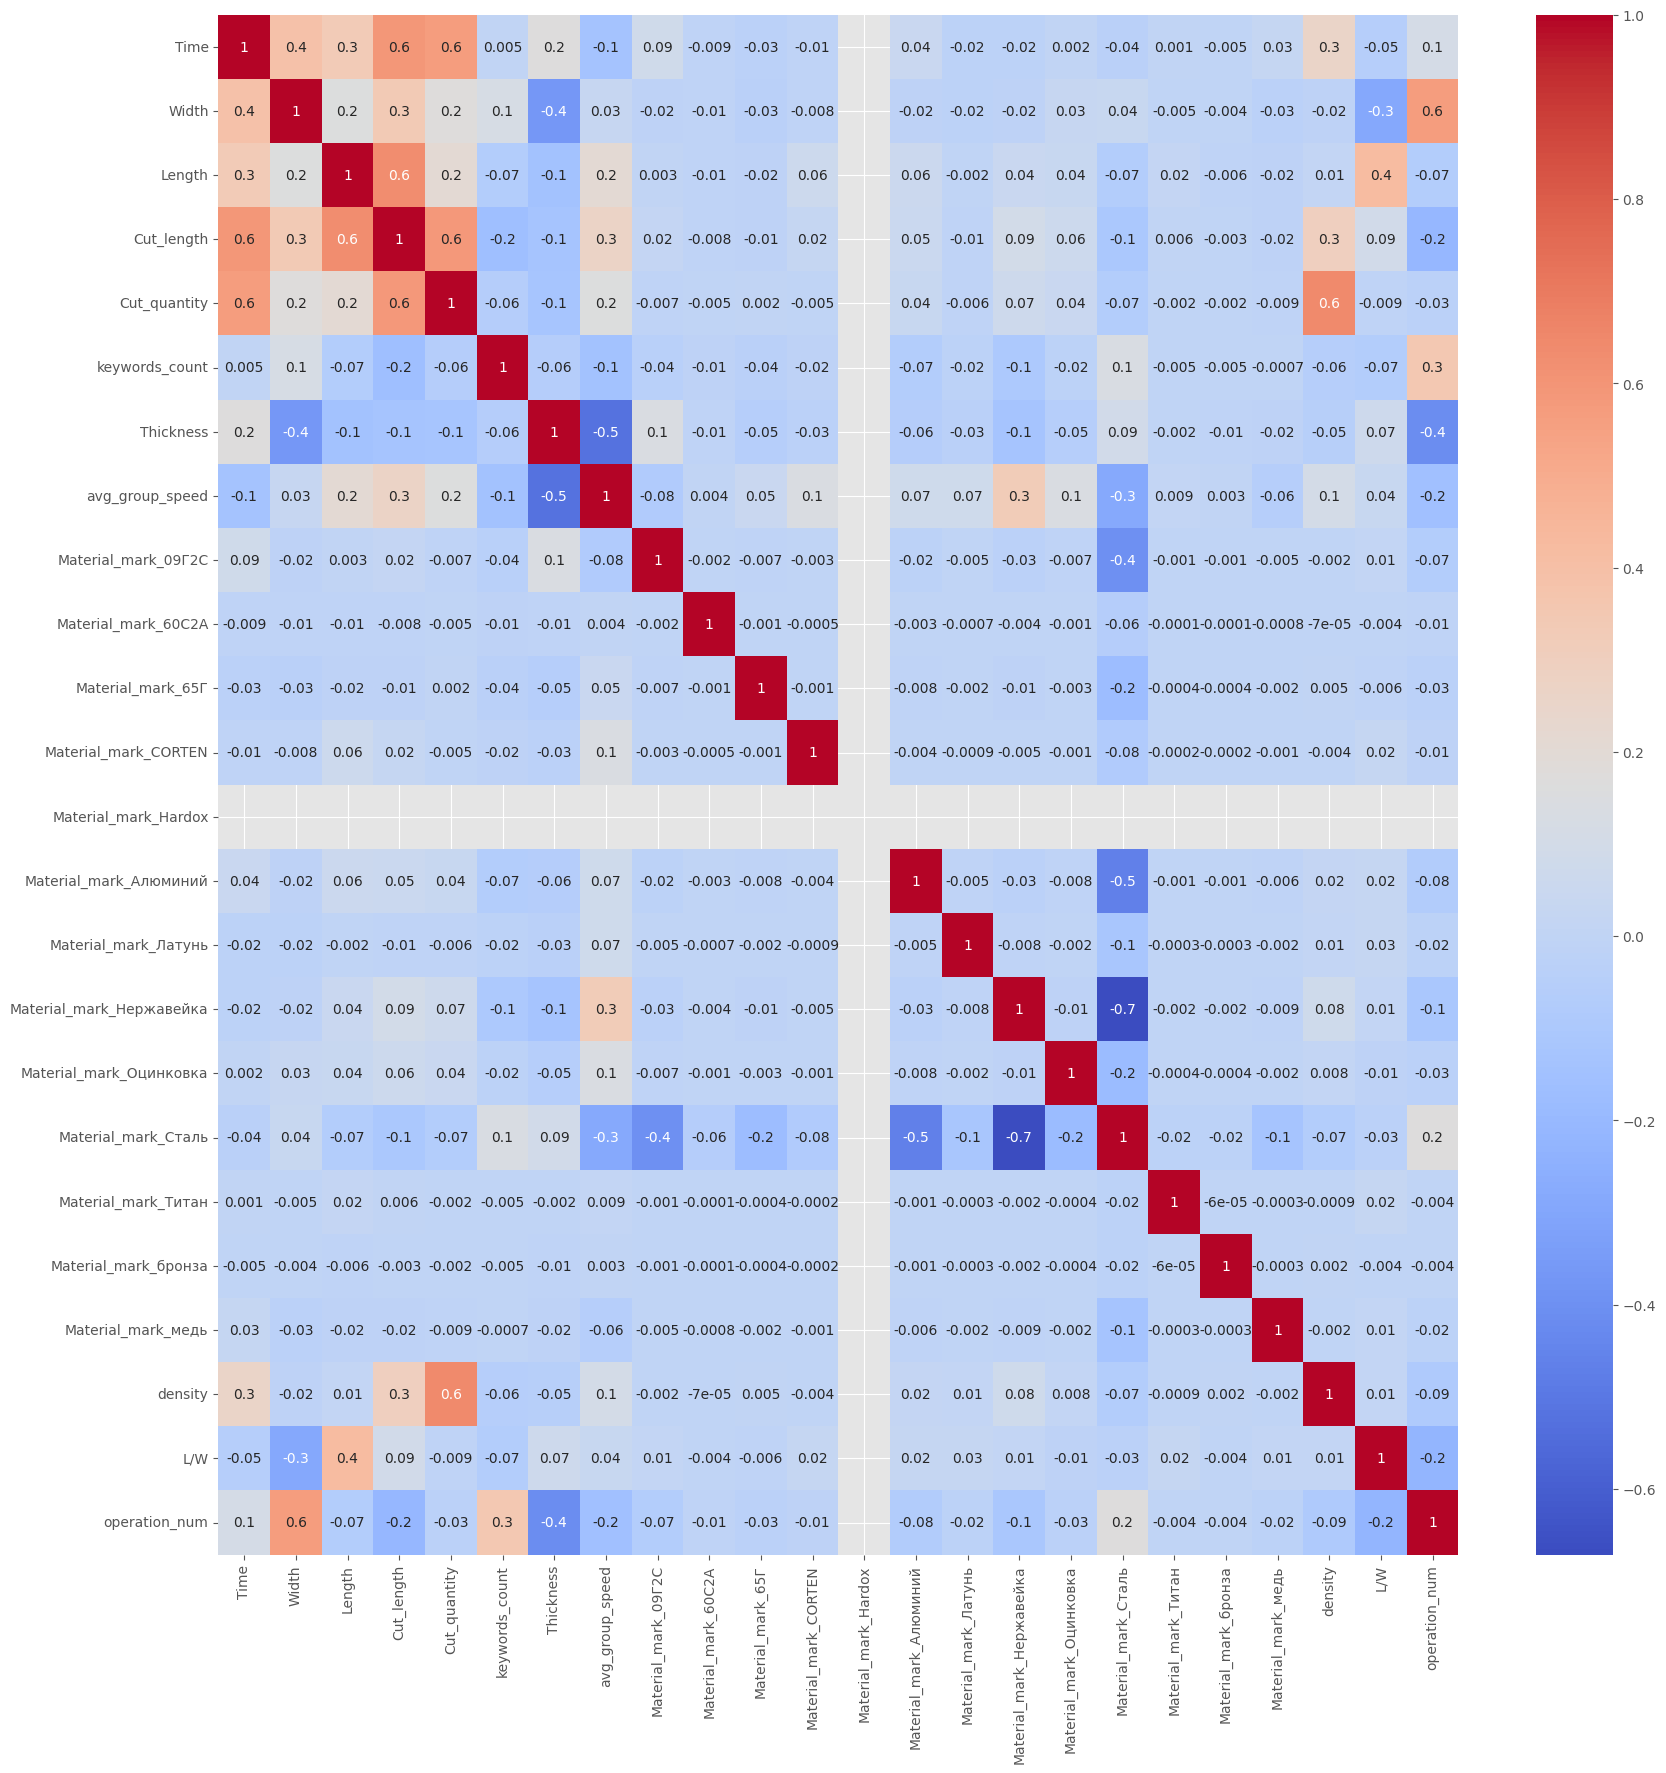

In [65]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(exp1.corr(), annot = True, ax=ax, fmt='.1g', cmap= 'coolwarm');

Разделим на выборки

In [66]:
X = exp1.drop('Time', axis=1)
y = exp1['Time']

exp1_X_train, exp1_X_temp, exp1_y_train, exp1_y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42)

exp1_X_val, exp1_X_test, exp1_y_val, exp1_y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

Создадим датасет для сравнения, добавим baseline

Для baseline просто считаем по школьной формуле

In [67]:
compare = exp1_X_test.copy()
compare['base_y_pred'] = compare['Cut_length'] / compare['avg_group_speed']
compare = compare.join(exp1_y_test)

In [68]:
compare.head(3)

,Width,Length,Cut_length,Cut_quantity,keywords_count,Thickness,avg_group_speed,Material_mark_09Г2С,Material_mark_60С2А,Material_mark_65Г,Material_mark_CORTEN,Material_mark_Hardox,Material_mark_Алюминий,Material_mark_Латунь,Material_mark_Нержавейка,Material_mark_Оцинковка,Material_mark_Сталь,Material_mark_Титан,Material_mark_бронза,Material_mark_медь,density,L/W,operation_num,base_y_pred,Time
405302,215.000,1300.000,4467,25,22.000,1.200,65.548,0,0,0,0,0,0,0,0,0,1,0,0,0,0.400,6.047,1,68.148,70.000
250899,140.000,140.000,642,6,239.000,6.000,19.749,0,0,0,0,0,0,0,0,0,1,0,0,0,0.197,1.000,1,32.508,40.000
398875,174.000,174.000,1034,10,80.667,2.000,47.721,0,0,0,0,0,0,0,1,0,0,0,0,0,0.342,1.000,1,21.668,19.000


In [69]:
sorted_compare = compare.sort_index()

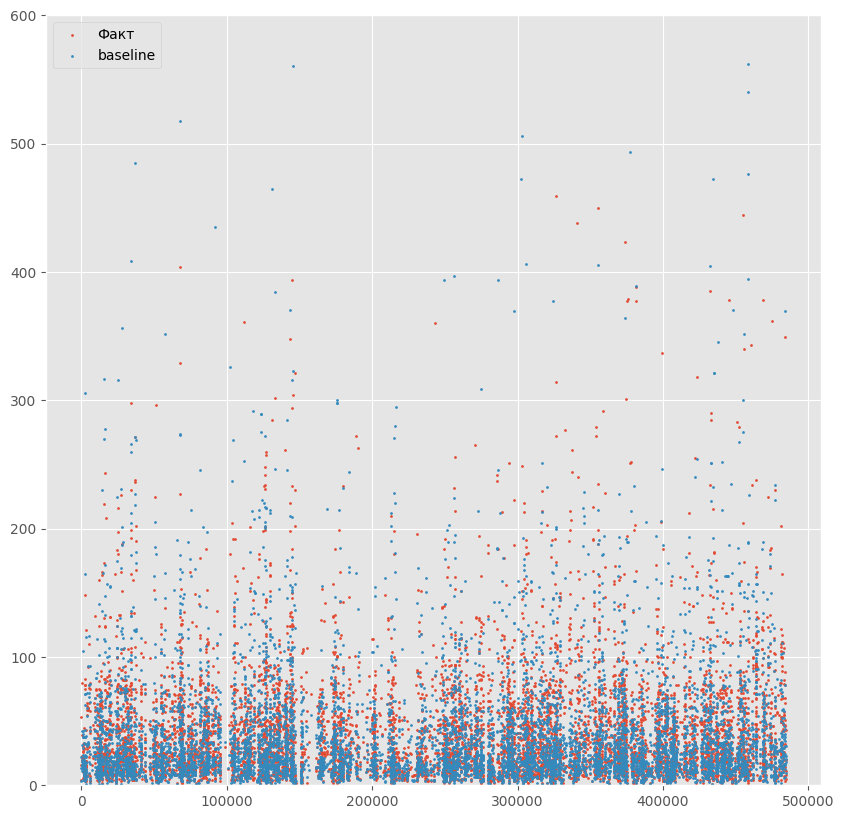

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(sorted_compare.index, sorted_compare['Time'], label = 'Факт', s=2)
ax.scatter(sorted_compare.index, sorted_compare['base_y_pred'], label = 'baseline', s=2)
ax.legend()
ax.set_ylim([0,600]);

Посчитаем метрики для baseline

In [71]:
actual_values = compare['Time']
predicted_values = compare['base_y_pred']

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"RMSE: {rmse}")

# Вычисление MAPE
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAPE: {mape * 100:.2f}%")

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Вычисление SMAPE
smape_value = smape(actual_values, predicted_values)
print(f"SMAPE: {smape_value:.2f}%")

r2 = r2_score(actual_values, predicted_values)
print(f"R^2: {r2:.2f}")

absolute_percentage_error = np.abs((exp1_y_test - predicted_values) / exp1_y_test)
percentage_within = np.mean(absolute_percentage_error <= 0.20) * 100
print(f"Процент значений с ошибкой не более 20%: {percentage_within:.2f}%")

RMSE: 35.3924914358448
MAPE: 48.04%
SMAPE: 39.18%
R^2: 0.31
Процент значений с ошибкой не более 20%: 43.13%


Обучаем линейную регрессию. Сначала стандартизируем данные

In [72]:
scaler = StandardScaler()
#scaler = QuantileTransformer(random_state=0)

exp1_X_train_scaled = pd.DataFrame(scaler.fit_transform(exp1_X_train),
                                   columns=exp1_X_train.columns, index=exp1_X_train.index)
exp1_X_val_scaled = pd.DataFrame(scaler.transform(exp1_X_val),
                                   columns=exp1_X_val.columns, index=exp1_X_val.index)

In [73]:
cols=['Cut_length', 'Material_mark_09Г2С', 'Material_mark_60С2А',
                 'Material_mark_65Г', 'Material_mark_CORTEN', 'Material_mark_Hardox',
                 'Material_mark_Алюминий', 'Material_mark_Латунь', 'Material_mark_Нержавейка',
                 'Material_mark_Оцинковка', 'Material_mark_Сталь', 'Material_mark_Титан',
                 'Material_mark_бронза', 'Material_mark_медь', 'Cut_quantity', 'Thickness',
      'density', 'operation_num']
X = exp1_X_train[cols]
y = exp1_y_train

reg = LinearRegression()
reg.fit(X, y)
y_linear_exp1_predict = reg.predict(exp1_X_test[cols])
compare['y_linear_exp1_predict'] = y_linear_exp1_predict

In [74]:
# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(exp1_y_test, y_linear_exp1_predict))
print(f"RMSE: {rmse}")

# Вычисление MAPE
mape = mean_absolute_percentage_error(exp1_y_test, y_linear_exp1_predict)
print(f"MAPE: {mape * 100:.2f}%")

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Вычисление SMAPE
smape_value = smape(exp1_y_test, y_linear_exp1_predict)
print(f"SMAPE: {smape_value:.2f}%")

r2 = r2_score(exp1_y_test, y_linear_exp1_predict)
print(f"R^2: {r2:.2f}")

absolute_percentage_error = np.abs((exp1_y_test - y_linear_exp1_predict) / exp1_y_test)
percentage_within = np.mean(absolute_percentage_error <= 0.20) * 100
print(f"Процент значений с ошибкой не более 20%: {percentage_within_10:.2f}%")

RMSE: 24.616538738091194
MAPE: 68.20%
SMAPE: 51.04%
R^2: 0.67
Процент значений с ошибкой не более 20%: 24.80%


## Сравнение моделей на графиках

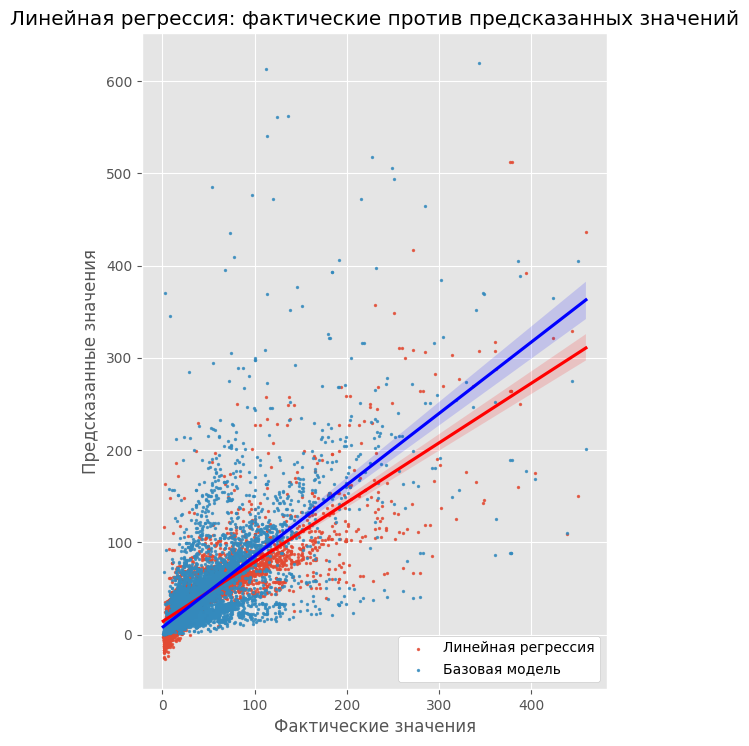

In [75]:
plt.figure(figsize=(6, 10)) 

sns.regplot(x=exp1_y_test, y=y_linear_exp1_predict, line_kws={"color":"red"},
           scatter_kws={'s': 2}, label='Линейная регрессия')
sns.regplot(x=exp1_y_test, y=compare['base_y_pred'], line_kws={"color":"blue"}, 
            scatter_kws={'s': 2}, label='Базовая модель')


plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Линейная регрессия: фактические против предсказанных значений')
plt.grid(True)
plt.legend(loc='best', facecolor='white', framealpha=1)

# Устанавливаем одинаковый масштаб для осей
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Пока что школьная формула работает значительно лучше регресси (хоть и имеет больше выбросов). Как минимум не предсказывает отрицательное время.

Но оба варианта работают плохо

In [76]:
def get_percent_error(pred, fact):
    error = abs(fact - pred)
    return error / fact * 100

In [77]:
compare.sort_values(by='Time', inplace=True)

In [78]:
compare['base_percent_error'] = compare.apply(lambda x: get_percent_error(x['base_y_pred'], x['Time']), axis=1)
compare['linear_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_linear_exp1_predict'], x['Time']), axis=1)

compare

,Width,Length,Cut_length,Cut_quantity,keywords_count,Thickness,avg_group_speed,Material_mark_09Г2С,Material_mark_60С2А,Material_mark_65Г,Material_mark_CORTEN,Material_mark_Hardox,Material_mark_Алюминий,Material_mark_Латунь,Material_mark_Нержавейка,Material_mark_Оцинковка,Material_mark_Сталь,Material_mark_Титан,Material_mark_бронза,Material_mark_медь,density,L/W,operation_num,base_y_pred,Time,y_linear_exp1_predict,base_percent_error,linear_percent_error
433869,11.000,11.000,35,1,18.000,2.500,32.681,0,0,0,0,0,0,0,0,0,1,0,0,0,0.289,1.000,1,1.071,1.000,-2.146,7.095,314.644
303797,10.000,10.000,31,1,54.000,2.000,47.721,0,0,0,0,0,0,0,1,0,0,0,0,0,0.310,1.000,1,0.650,1.000,-2.358,35.039,335.826
331266,36.000,14.000,113,1,20.000,2.000,23.124,0,0,0,0,0,0,0,0,0,1,0,0,0,0.224,0.389,1,4.887,2.000,-4.898,144.332,344.891
78816,12.000,12.000,60,2,273.000,0.800,65.627,0,0,0,0,0,0,0,0,0,1,0,0,0,0.833,1.000,1,0.914,2.000,-16.294,54.287,914.701
283928,8.000,4.000,22,1,1.000,3.000,9.857,0,0,0,0,0,0,1,0,0,0,0,0,0,0.688,0.500,1,2.232,2.000,8.021,11.594,301.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373951,971.000,530.000,14030,127,2.000,3.000,38.510,0,0,0,0,0,0,0,0,0,1,0,0,0,3.462,0.546,1,364.319,423.000,321.801,13.873,23.924
340693,1689.000,145.000,2551,42,1490.000,2.000,23.124,0,0,0,0,0,0,0,0,0,1,0,0,0,0.437,0.086,2,110.317,438.000,109.450,74.813,75.011
454756,248.000,327.000,13119,274,2.000,2.000,47.721,0,0,0,0,0,0,0,1,0,0,0,0,0,44.325,1.319,1,274.913,444.000,329.121,38.083,25.874
355471,195.000,470.000,3838,15,1080.000,12.000,9.466,0,0,0,0,0,0,0,0,0,1,0,0,0,0.628,2.410,1,405.430,450.000,150.091,9.904,66.646


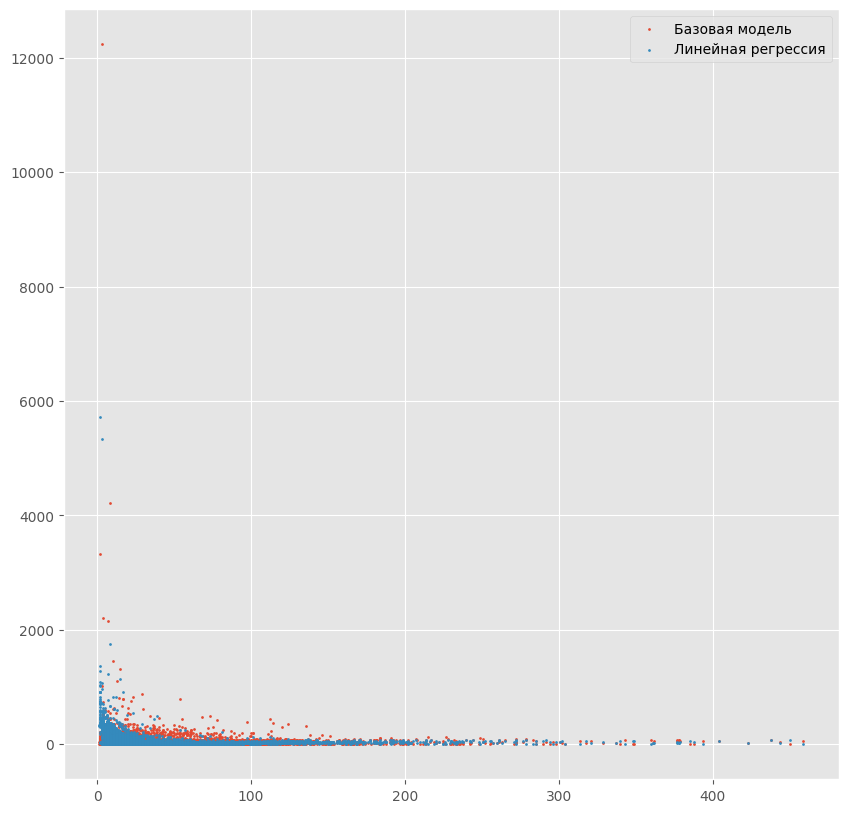

In [79]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(compare['Time'], compare['base_percent_error'] , label = 'Базовая модель', s=2)
ax.scatter(compare['Time'], compare['linear_percent_error'], label = 'Линейная регрессия', s=2)
ax.legend(loc='best');

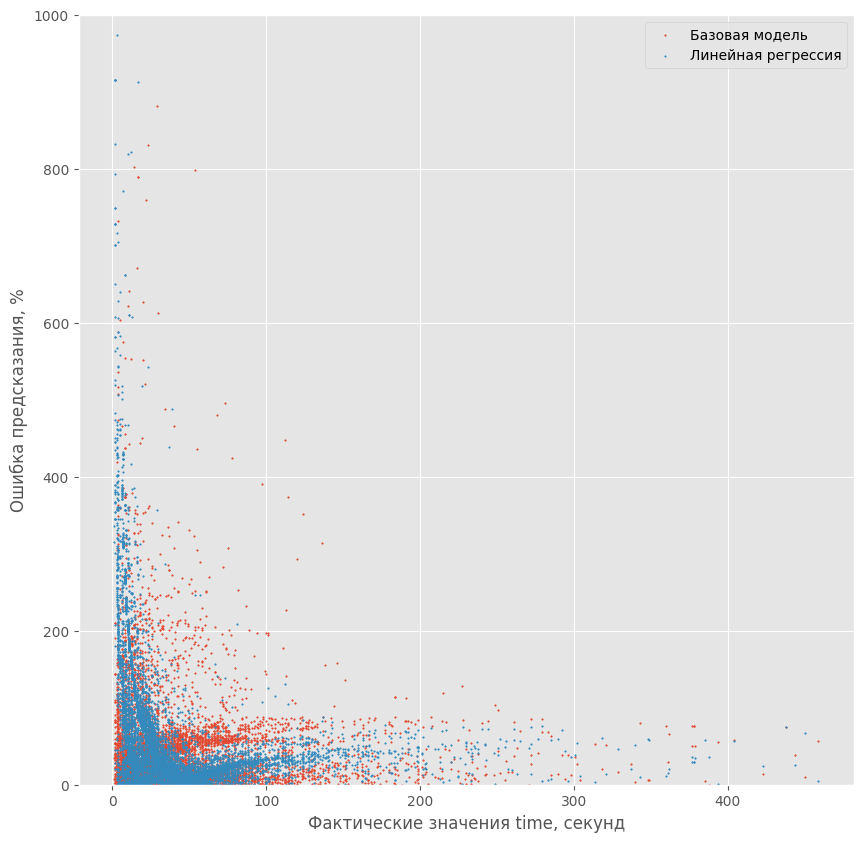

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(compare['Time'], compare['base_percent_error'] , label = 'Базовая модель', s=1)
ax.scatter(compare['Time'], compare['linear_percent_error'], label = 'Линейная регрессия', s=1)
ax.legend(loc='best')
ax.set_xlabel('Фактические значения time, секунд')
ax.set_ylabel("Ошибка предсказания, %")
ax.set_ylim([0,1000]);